# DS-GA 1011 Lab 8 Neural Machine Translation with Seq2Seq model and Attention

Adapted from the PyTorch tutorials (https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

In this lab we will be teaching a neural network to translate from French to English.
::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <http://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.


To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.



In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
device

device(type='cuda')

## Loading Data

Download the data from https://download.pytorch.org/tutorial/data.zip and unzip the file in the location of the notebook.
    
We'll use data/eng-fra.txt where each line in the file is a tab separated pair of English and French word sequence:

    I am cold.    J'ai froid.


## Preprocess Data

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count to use to later replace rare words.

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English I added the reverse flag to reverse the pairs.

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['ils sont tous ici .', 'they re all here .']


In [8]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [29]:
n_iters = 1
training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

input_tensor, target_tensor = training_pairs[0][0], training_pairs[0][1]

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, emb_size,  hidden_size, vocab_size):
        super(EncoderRNN, self).__init__()
        self.num_layers = 2
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx = 0)
        self.gru = nn.GRU(emb_size, hidden_size, 2, batch_first=True, bidirectional=True)

    def forward(self, s0, hidden):
        embedded = self.embedding(s0)
        embedded = embedded.view(1,1,-1)
        rnn_out, hidden = self.gru(embedded, hidden)
        return rnn_out, hidden
    
    def initHidden(self):
        return torch.zeros(2*self.num_layers, 1, self.hidden_size, device=device)
    
#     def initHidden(self, batch_size):
#         return torch.randn(2*self.num_layers, batch_size, self.hidden_size, device=device)

In [13]:
input_length = 9

In [23]:
encoder1 = EncoderRNN(emb_size, hidden_size, input_lang.n_words).to(device)
encoder_hidden = torch.randn(2*2, 1, hidden_size, device=device)
for ei in range(input_length):
    encoder_output, encoder_hidden = encoder1(
        input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]

In [24]:
encoder_output.size()

torch.Size([1, 1, 512])

In [25]:
input_tensor[1], input_tensor[1].size()

(tensor([118], device='cuda:0'), torch.Size([1]))

In [79]:
encoder_hidden.size()

torch.Size([4, 1, 256])

In [64]:
class DecoderRNN(nn.Module):
    def __init__(self, emb_size,  hidden_size, vocab_size):
        super(DecoderRNN, self).__init__()
        self.num_layers = 2
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx = 0)
        self.gru = nn.GRU(emb_size, hidden_size, 2, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(self.num_layers*hidden_size, vocab_size) ## The output of GRU has the same length as sentence length.
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, s1, hidden):
        embedded = self.embedding(s1)
        embedded = F.relu(embedded)
        embedded = embedded.view(1,1,-1)
        rnn_out, hidden = self.gru(embedded, hidden)
        rnn_out = self.linear(rnn_out)
        rnn_out = self.softmax(rnn_out.squeeze(1))
        return rnn_out, hidden

In [52]:
target_length = 9
loss = 0
criterion = nn.NLLLoss()

In [53]:
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_input.size()

torch.Size([1, 1])

In [110]:
teacher_forcing_ratio = 0.5


#def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(input_length, 2*encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [62]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [71]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [69]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [129]:
def evaluateRandomly_noAttn(encoder, decoder, n=10):
    """
    Randomly select a English sentence from the dataset and try to produce its French translation.
    Note that you need a correct implementation of evaluate() in order to make this function work.
    """    
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words  = evaluate_noAttn(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

0m 13s (- 3m 29s) (500 6%) 3.4532
0m 27s (- 3m 14s) (1000 12%) 3.2306
0m 41s (- 2m 59s) (1500 18%) 2.9140
0m 55s (- 2m 45s) (2000 25%) 2.7018
1m 9s (- 2m 32s) (2500 31%) 2.6386
1m 22s (- 2m 18s) (3000 37%) 2.4419
1m 36s (- 2m 4s) (3500 43%) 2.3607
1m 50s (- 1m 50s) (4000 50%) 2.2567
2m 4s (- 1m 36s) (4500 56%) 2.1731
2m 18s (- 1m 22s) (5000 62%) 2.0734
2m 32s (- 1m 9s) (5500 68%) 2.0451
2m 46s (- 0m 55s) (6000 75%) 2.0532
2m 59s (- 0m 41s) (6500 81%) 2.0051
3m 13s (- 0m 27s) (7000 87%) 1.8491
3m 27s (- 0m 13s) (7500 93%) 1.8873
3m 41s (- 0m 0s) (8000 100%) 1.9481


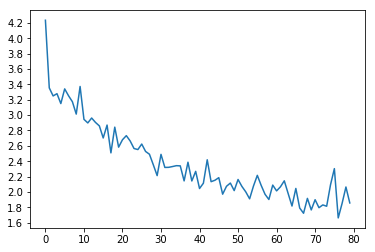

In [111]:
emb_size = 200
hidden_size = 256
encoder1 = EncoderRNN(emb_size, hidden_size, input_lang.n_words).to(device)
# attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
#attn_decoder1 = BahdanauAttnDecoderRNN(hidden_size, output_lang.n_words, n_layers=1, dropout_p=0.1).to(device)
decoder1 = DecoderRNN(emb_size, hidden_size, output_lang.n_words).to(device)

##UNCOMMENT TO TRAIN THE MODEL
trainIters(encoder1, decoder1, 8000, print_every=500)

# encoder1.load_state_dict(torch.load("encoder.pth"))
# attn_decoder1.load_state_dict(torch.load("attn_decoder.pth"))

In [83]:
def evaluate_noAttn(encoder, decoder, sentence):
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        # encode the source lanugage
        encoder_hidden = encoder.initHidden()

        #encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            #encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        # decode the context vector
        decoder_hidden = encoder_hidden # decoder starts from the last encoding sentence
        # output of this function
        decoded_words = []
        #decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(input_length):
            # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            # hint: print out decoder_output and decoder_attention
            # TODO: add your code here to populate decoded_words and decoder_attentions
            # TODO: do this in 2 ways discussed in class: greedy & beam_search
            #decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            
            # END TO DO
            
            decoder_input = topi.squeeze().detach()

        return decoded_words #, decoder_attentions[:di + 1]

In [125]:
n = random.randint(0, 500)
eval_pairs = pairs[n]
eval_input = eval_pairs[0]
print(eval_pairs)
predict = evaluate_noAttn(encoder1, decoder1, eval_input)
print(predict)

['elle est occupee .', 'she s busy .']
['she', 's', 'busy', 'with', '.']


In [130]:
evaluateRandomly_noAttn(encoder1, decoder1)

> ils sont conscients des difficultes .
= they are aware of the difficulties .
< they are aware . <EOS>

> nous ne sommes pas assures .
= we re uninsured .
< we re not evil . <EOS>

> c est moi la patronne par ici .
= i m the boss around here .
< i m in charge here . <EOS>

> je suis fatigue maintenant .
= i m tired now .
< i m tired of your .

> je suis celle qui a construit ceci .
= i m the one who built this .
< i m the one one trained me . <EOS>

> il passe a la radio .
= he is on the radio .
< he s playing to the . <EOS>

> nous sommes tres proches .
= we re very close .
< we re very close . <EOS>

> je suis desolee si je vous ai embarrassee .
= i m sorry if i embarrassed you .
< i m sorry if i disturbed you . <EOS>

> nous sommes normaux .
= we re normal .
< we re stuffed . <EOS>

> il n est pas marie .
= he is unmarried .
< he isn t married . <EOS>

